## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

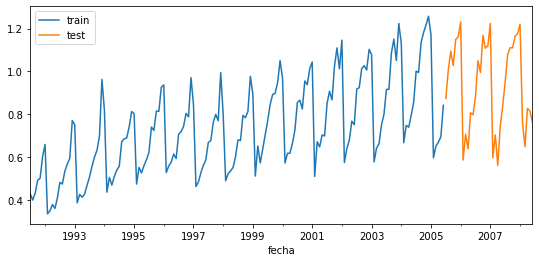

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## GridSearch

In [3]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Placeholder, the value will be overwritten
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

2021-08-13 14:31:39,108 root       INFO  Number of models to fit: 12
loop lags_grid: 100%|██████████| 3/3 [00:14<00:00,  4.74s/it] 
2021-08-13 14:31:53,322 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



In [6]:
print(results_grid.to_markdown())

|    | lags                            | params                                 |    metric |
|---:|:--------------------------------|:---------------------------------------|----------:|
|  6 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 50}  | 0.0265202 |
|  4 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 50}   | 0.0269665 |
|  7 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 10, 'n_estimators': 100} | 0.0280916 |
|  5 | [ 1  2  3  4  5  6  7  8  9 10] | {'max_depth': 5, 'n_estimators': 100}  | 0.0286928 |
| 11 | [ 1  2  3 20]                   | {'max_depth': 10, 'n_estimators': 100} | 0.0295003 |
|  0 | [1 2 3]                         | {'max_depth': 5, 'n_estimators': 50}   | 0.0332516 |
|  9 | [ 1  2  3 20]                   | {'max_depth': 5, 'n_estimators': 100}  | 0.0338282 |
|  1 | [1 2 3]                         | {'max_depth': 5, 'n_estimators': 100}  | 0.0341536 |
|  8 | [ 1  2  3 20]                   | {'max_depth': 5, 'n

## Prediction

In [42]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(3)

fecha
2005-07-01    0.973131
2005-08-01    1.022154
2005-09-01    1.151334
Freq: MS, dtype: float64

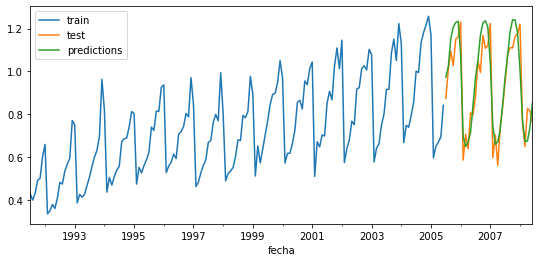

In [43]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [44]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.009918738501371805


## Feature importance

In [45]:
# When using as regressor LinearRegression, Ridge or Lasso
forecaster.get_coef()

# When using as regressor RandomForestRegressor or GradientBoostingRegressor
# forecaster.get_feature_importances()

array([ 1.58096176e-01,  6.18241513e-02,  6.44665806e-02, -2.41792429e-02,
       -2.60679572e-02,  7.04191008e-04, -4.28090339e-02,  4.87464352e-04,
        1.66853207e-02,  1.00022527e-02,  1.62219885e-01,  6.15595305e-01,
        2.85168042e-02, -7.31915864e-02, -5.38785052e-02])

## Extract training matrix

In [46]:
X, y = forecaster.create_train_X_y(data_train)